In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
import glob
import act
import matplotlib.pyplot as plt
import xarray as xr
import scipy.signal
import datetime as dt
import scipy
import altair as alt
import swifter

# User Inputs

In [2]:
# This data was put here and cleaned using the `doppler_lidar_mass_download.py` script
input_directory = '/data2/elilouis/sublimationofsnow/gucdlfptM1.b1/winter/downsampled'
# input_directory = '/data2/elilouis/sublimationofsnow/gucdlfptM1.b1/spring/downsampled'
# input_directory = '/data2/elilouis/sublimationofsnow/gucdlfptM1.b1/alldatatodate/downsampled/'

# Plan including 20 minutes of vertical staring in 4 separate chunks of 5 minutes
plan_1_vertical_staring_minutes = [
    15,16,17,18,19,24,25,26,27,28,45,46,47,48,49,54,55,56,57,58
]
# Plan including 20 minutes of vertical staring in 2 separate chunks of 3 and 2 separate chunks of 7 minutes
plan_2_vertical_staring_minutes = [
    11,12,13,22,23,24,25,26,27,28,41,42,43,52,53,54,55,56,57,58
]

plan_3_vertical_staring_minutes = [
    7,8,9,10,11,12,13,22,23,24,25,26,27,28,37,38,39,40,41,42,43,52,53,54,55,56,57,58
]

In [3]:
if 'alldatatodate' in input_directory:
    dl_fpt_files = glob.glob(os.path.join(input_directory, '*/*.cdf'), recursive=True)
else:
    dl_fpt_files = glob.glob(os.path.join(input_directory, '*.cdf'), recursive=True)

In [4]:
dl_fpt = act.io.armfiles.read_netcdf(dl_fpt_files)

ERROR 1: PROJ: proj_create_from_database: Open of /home/elilouis/mambaforge/envs/arm/share/proj failed


<AxesSubplot: title={'center': 'Gothic Doppler LiDAR radial_velocity on 20211201'}, xlabel='Time [UTC]', ylabel='(m)'>

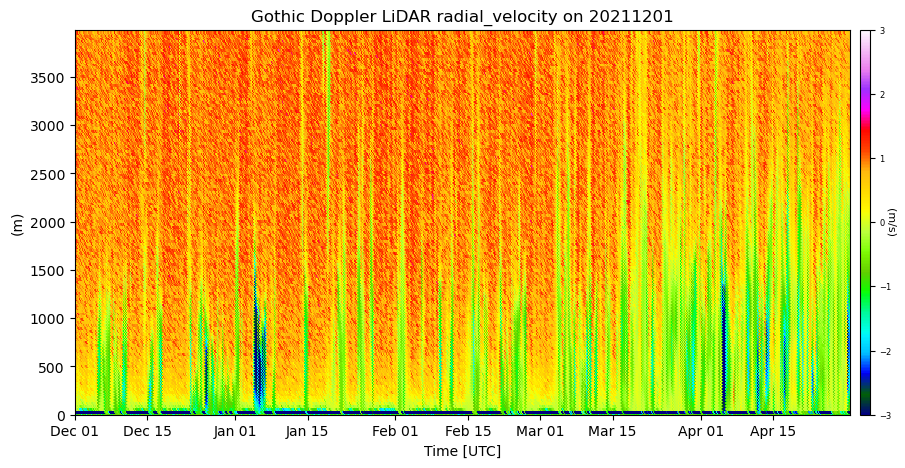

In [5]:
dl_fpt_plotting = dl_fpt.resample(time='240Min').mean()


display = act.plotting.TimeSeriesDisplay(
    {'Gothic Doppler LiDAR': dl_fpt_plotting},
    subplot_shape=(1,),
    figsize=(10, 5),
)

display.plot(
    'radial_velocity',
    dsname='Gothic Doppler LiDAR',
    cmap='gist_ncar',
    vmin=-3,
    vmax=3,
    subplot_index=(0,)
)


<AxesSubplot: title={'center': 'Gothic Doppler LiDAR radial_velocity on 20220101'}, xlabel='Time [UTC]', ylabel='(m)'>

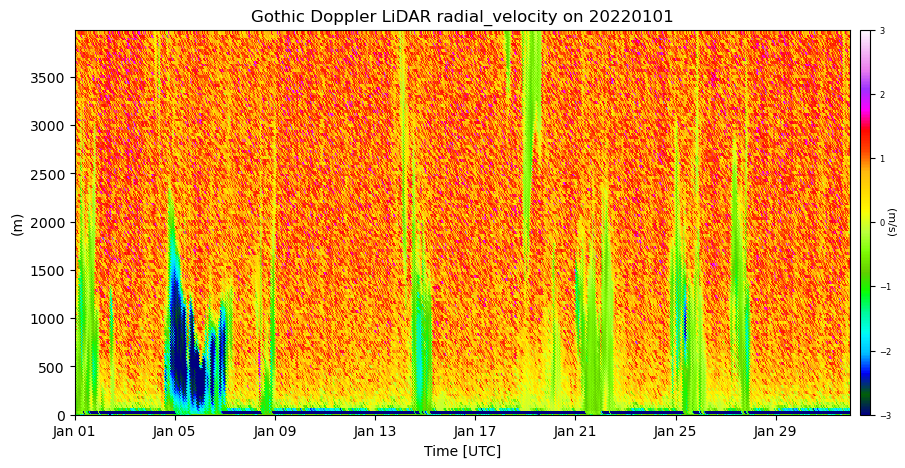

In [6]:
if 'winter' in input_directory:
    dl_fpt_plotting = dl_fpt.sel(time=slice('2022-01-01', '2022-01-31'))
elif 'spring' in input_directory:
    dl_fpt_plotting = dl_fpt.sel(time=slice('2022-05-01', '2022-05-31'))
else:
    dl_fpt_plotting = dl_fpt.sel(time=slice('2022-01-01', '2022-01-31'))

dl_fpt_plotting = dl_fpt_plotting.resample(time='60Min').mean()

display = act.plotting.TimeSeriesDisplay(
    {'Gothic Doppler LiDAR': dl_fpt_plotting},
    subplot_shape=(1,),
    figsize=(10, 5),
)

display.plot(
    'radial_velocity',
    dsname='Gothic Doppler LiDAR',
    cmap='gist_ncar',
    vmin=-3,
    vmax=3,
    subplot_index=(0,)
)


<AxesSubplot: title={'center': 'Gothic Doppler LiDAR radial_velocity on 20220104'}, xlabel='Time [UTC]', ylabel='(m)'>

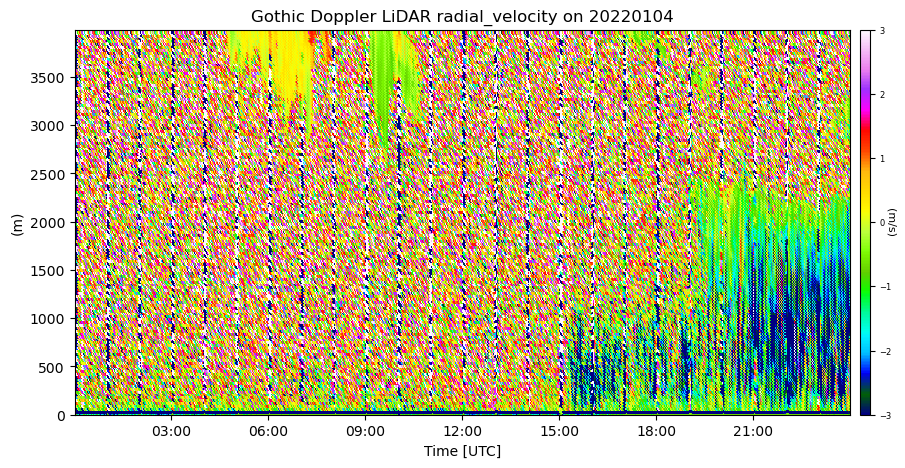

In [7]:
if 'winter' in input_directory:
    dl_fpt_plotting = dl_fpt.sel(time=slice('2022-01-04', '2022-01-04'))
elif 'spring' in input_directory:
    dl_fpt_plotting = dl_fpt.sel(time=slice('2022-05-05', '2022-05-05'))
else:
    dl_fpt_plotting = dl_fpt.sel(time=slice('2022-01-04', '2022-01-04'))

dl_fpt_plotting = dl_fpt_plotting.resample(time='1Min').mean()

display = act.plotting.TimeSeriesDisplay(
    {'Gothic Doppler LiDAR': dl_fpt_plotting},
    subplot_shape=(1,),
    figsize=(10, 5),
)

display.plot(
    'radial_velocity',
    dsname='Gothic Doppler LiDAR',
    cmap='gist_ncar',
    vmin=-3,
    vmax=3,
    subplot_index=(0,)
)


# Create DF

In [8]:
src_fpt = dl_fpt.to_dataframe().reset_index()

# Save the DF to save time on future runs

In [9]:
src_fpt.to_pickle('vertical_staring.pkl')

In [10]:
src_fpt = pd.read_pickle('vertical_staring.pkl')

In [11]:
len(src_fpt)

26293302

## Filter SNR

In [12]:
src_fpt['SNR'] = src_fpt['intensity'] - 1
src_fpt = src_fpt.query('SNR > 0.008')

In [13]:
len(src_fpt)

5274388

# Create "modeled" dataset representing the proposed loss of data (for other scans)

In [14]:
src_fpt['range_group'] = pd.cut(
    src_fpt['range'],
    [0, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000],
    labels=[200, 600, 1000, 1400, 1800, 2200, 2600, 3000, 3400, 3800]
)

In [15]:
src_fpt['minutes'] = src_fpt['time'].dt.minute
 
src_fpt_plan_1 = src_fpt[src_fpt['minutes'].isin(plan_1_vertical_staring_minutes)]

src_fpt_plan_2 = src_fpt[src_fpt['minutes'].isin(plan_2_vertical_staring_minutes)]

src_fpt_plan_3 = src_fpt[src_fpt['minutes'].isin(plan_3_vertical_staring_minutes)]

In [16]:
len(src_fpt), len(src_fpt_plan_1), len(src_fpt_plan_2), len(src_fpt_plan_3)

(5274388, 1900452, 1915752, 2684174)

# Bin the range/elevation values

In [17]:
src_fpt_grouped = src_fpt[['time', 'radial_velocity', 'range_group']].groupby(['time', 'range_group']).mean().reset_index().dropna()
 
src_fpt_plan_1_grouped = src_fpt_plan_1[['time', 'radial_velocity', 'range_group']].groupby(['time', 'range_group']).mean().reset_index().dropna()

src_fpt_plan_2_grouped = src_fpt_plan_2[['time', 'radial_velocity', 'range_group']].groupby(['time', 'range_group']).mean().reset_index().dropna()

src_fpt_plan_3_grouped = src_fpt_plan_3[['time', 'radial_velocity', 'range_group']].groupby(['time', 'range_group']).mean().reset_index().dropna()

# Calculate vertical profiles of velocity statistics

In [18]:
variance_all_data = pd.DataFrame(src_fpt_grouped.groupby('range_group')['radial_velocity'].apply(np.var)).reset_index().rename(columns={'radial_velocity': 'value'})
variance_all_data['statistic'] = 'variance'
variance_all_data['mode'] = 'Existing Plan'
skew_all_data = pd.DataFrame(src_fpt_grouped.groupby('range_group')['radial_velocity'].apply(scipy.stats.skew)).reset_index().rename(columns={'radial_velocity': 'value'})
skew_all_data['statistic'] = 'skew'
skew_all_data['mode'] = 'Existing Plan'
kurt_all_data = pd.DataFrame(src_fpt_grouped.groupby('range_group')['radial_velocity'].apply(scipy.stats.kurtosis)).reset_index().rename(columns={'radial_velocity': 'value'})
kurt_all_data['statistic'] = 'kurtosis'
kurt_all_data['mode'] = 'Existing Plan'

variance_plan_1 = pd.DataFrame(src_fpt_plan_1_grouped.groupby('range_group')['radial_velocity'].apply(np.var)).reset_index().rename(columns={'radial_velocity': 'value'})
variance_plan_1['statistic'] = 'variance'
variance_plan_1['mode'] = 'Plan 1'
skew_plan_1 = pd.DataFrame(src_fpt_plan_1_grouped.groupby('range_group')['radial_velocity'].apply(scipy.stats.skew)).reset_index().rename(columns={'radial_velocity': 'value'})
skew_plan_1['statistic'] = 'skew'
skew_plan_1['mode'] = 'Plan 1'
kurt_plan_1 = pd.DataFrame(src_fpt_plan_1_grouped.groupby('range_group')['radial_velocity'].apply(scipy.stats.kurtosis)).reset_index().rename(columns={'radial_velocity': 'value'})
kurt_plan_1['statistic'] = 'kurtosis'
kurt_plan_1['mode'] = 'Plan 1'

variance_plan_2 = pd.DataFrame(src_fpt_plan_2_grouped.groupby('range_group')['radial_velocity'].apply(np.var)).reset_index().rename(columns={'radial_velocity': 'value'})
variance_plan_2['statistic'] = 'variance'
variance_plan_2['mode'] = 'Plan 2'
skew_plan_2 = pd.DataFrame(src_fpt_plan_2_grouped.groupby('range_group')['radial_velocity'].apply(scipy.stats.skew)).reset_index().rename(columns={'radial_velocity': 'value'})
skew_plan_2['statistic'] = 'skew'
skew_plan_2['mode'] = 'Plan 2'
kurt_plan_2 = pd.DataFrame(src_fpt_plan_2_grouped.groupby('range_group')['radial_velocity'].apply(scipy.stats.kurtosis)).reset_index().rename(columns={'radial_velocity': 'value'})
kurt_plan_2['statistic'] = 'kurtosis'
kurt_plan_2['mode'] = 'Plan 2'

variance_plan_3 = pd.DataFrame(src_fpt_plan_3_grouped.groupby('range_group')['radial_velocity'].apply(np.var)).reset_index().rename(columns={'radial_velocity': 'value'})
variance_plan_3['statistic'] = 'variance'
variance_plan_3['mode'] = 'Plan 3'
skew_plan_3 = pd.DataFrame(src_fpt_plan_3_grouped.groupby('range_group')['radial_velocity'].apply(scipy.stats.skew)).reset_index().rename(columns={'radial_velocity': 'value'})
skew_plan_3['statistic'] = 'skew'
skew_plan_3['mode'] = 'Plan 3'
kurt_plan_3 = pd.DataFrame(src_fpt_plan_3_grouped.groupby('range_group')['radial_velocity'].apply(scipy.stats.kurtosis)).reset_index().rename(columns={'radial_velocity': 'value'})
kurt_plan_3['statistic'] = 'kurtosis'
kurt_plan_3['mode'] = 'Plan 3'

statistics = pd.concat([
    variance_all_data, skew_all_data, kurt_all_data, 
    variance_plan_1, skew_plan_1, kurt_plan_1,
    variance_plan_2, skew_plan_2, kurt_plan_2,
    variance_plan_3, skew_plan_3, kurt_plan_3
])

In [19]:
alt.Chart(statistics).mark_line(opacity=1).encode(
    alt.X('value:Q', sort='-y'),
    alt.Y('range_group:Q', title='Range (m)'),
    alt.Color('mode:N')
).properties(width=150, height=150).facet(
    column=alt.Column('statistic:N', sort=['variance', 'skew', 'kurtosis'])
).resolve_scale(x='independent', y='shared').display(renderer='svg')

alt.FacetChart(...)

# Calculate power spectral density functions for each range bin

## Demean radial velocity, add epoch information

In [20]:
src_fpt_grouped['radial_velocity group mean'] = src_fpt_grouped.groupby('range_group')['radial_velocity'].transform('mean')
src_fpt_grouped['radial_velocity_demeaned'] = src_fpt_grouped['radial_velocity'] - src_fpt_grouped['radial_velocity group mean']
src_fpt_grouped['epoch'] = (src_fpt_grouped['time'] - dt.datetime(1970,1,1)).dt.total_seconds()

src_fpt_plan_1_grouped['radial_velocity group mean'] = src_fpt_plan_1_grouped.groupby('range_group')['radial_velocity'].transform('mean')
src_fpt_plan_1_grouped['radial_velocity_demeaned'] = src_fpt_plan_1_grouped['radial_velocity'] - src_fpt_plan_1_grouped['radial_velocity group mean']
src_fpt_plan_1_grouped['epoch'] = (src_fpt_plan_1_grouped['time'] - dt.datetime(1970,1,1)).dt.total_seconds()

src_fpt_plan_2_grouped['radial_velocity group mean'] = src_fpt_plan_2_grouped.groupby('range_group')['radial_velocity'].transform('mean')
src_fpt_plan_2_grouped['radial_velocity_demeaned'] = src_fpt_plan_2_grouped['radial_velocity'] - src_fpt_plan_2_grouped['radial_velocity group mean']
src_fpt_plan_2_grouped['epoch'] = (src_fpt_plan_2_grouped['time'] - dt.datetime(1970,1,1)).dt.total_seconds()

src_fpt_plan_3_grouped['radial_velocity group mean'] = src_fpt_plan_3_grouped.groupby('range_group')['radial_velocity'].transform('mean')
src_fpt_plan_3_grouped['radial_velocity_demeaned'] = src_fpt_plan_3_grouped['radial_velocity'] - src_fpt_plan_3_grouped['radial_velocity group mean']
src_fpt_plan_3_grouped['epoch'] = (src_fpt_plan_3_grouped['time'] - dt.datetime(1970,1,1)).dt.total_seconds()

## Calculate power spectrum for each range bin

### Compare existing plan and plan 1

In [22]:
freqs = np.logspace(-9,-2, 100)

In [23]:
total_measurement_time_seconds = (src_fpt_grouped['time'].max() - src_fpt_grouped['time'].min()).total_seconds()
half_sampling_rate_seconds = 120

power_spectrum_df = pd.DataFrame()
for range_group in src_fpt_grouped['range_group'].unique():
    src = src_fpt_grouped[src_fpt_grouped['range_group'] == range_group]
    src_less_data = src_fpt_plan_1_grouped[src_fpt_plan_1_grouped['range_group'] == range_group]
    pgram = scipy.signal.lombscargle(
        src[['epoch', 'radial_velocity_demeaned']].dropna()['epoch'],
        src[['epoch', 'radial_velocity_demeaned']].dropna()['radial_velocity_demeaned'],
        freqs,
        normalize=True
    )
    pgram_less_data = scipy.signal.lombscargle(
        src_less_data[['epoch', 'radial_velocity_demeaned']].dropna()['epoch'],
        src_less_data[['epoch', 'radial_velocity_demeaned']].dropna()['radial_velocity_demeaned'],
        freqs,
        normalize=True
    )
    src_df = pd.DataFrame({'freqs': freqs, 'pgram': pgram})
    src_df['mode'] = 'more data'
    src_df['range_group'] = range_group
    src_less_data_df = pd.DataFrame({'freqs': freqs, 'pgram': pgram_less_data})
    src_less_data_df['mode'] = 'less data'
    src_less_data_df['range_group'] = range_group
    power_spectrum_df = pd.concat([power_spectrum_df, src_df, src_less_data_df])

In [24]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [25]:
psss = alt.Chart().mark_line(opacity=0.5).encode(
    alt.X('freqs:Q', scale=alt.Scale(type='log'), title='Frequency (hz)'),
    alt.Y('pgram:Q', scale=alt.Scale(type='log', 
    # domain=[0.1, 1000], 
    clamp=True), title='Power spectral density', axis=alt.Axis(grid=False)),
    alt.Color('mode')
).properties(height=150, width=500)

vertline_a = alt.Chart().mark_rule().encode(x='a:Q')
vertline_b = alt.Chart().mark_rule().encode(x='b:Q')
vertline_c = alt.Chart().mark_rule().encode(x='c:Q')
vertline_d = alt.Chart().mark_rule().encode(x='d:Q')
vertline_e = alt.Chart().mark_rule().encode(x='e:Q')
vertline_f = alt.Chart().mark_rule().encode(x='f:Q')
vertline_g = alt.Chart().mark_rule().encode(x='g:Q')
vertline_h = alt.Chart().mark_rule().encode(x='h:Q')
one_week = 1/(3600*24*7)
one_day = 1/(3600*24)
two_hours = 1/(2*3600)
one_hour = 1/(3600)
thirty_minutes = 1/(30*60)
twenty_minutes = 1/(20*60)
ten_minutes = 1/(10*60)
five_minutes = 1/(5*60)

alt.layer(
    vertline_a, vertline_b, vertline_c, vertline_d, 
    vertline_e, vertline_f, vertline_g, vertline_h,
    psss, 
    data=power_spectrum_df
).transform_calculate(
    a=str(one_week),
    b=str(one_day),
    c=str(two_hours),
    d=str(one_hour),
    e=str(thirty_minutes),
    f=str(twenty_minutes),
    g=str(ten_minutes),
    h=str(five_minutes)
).facet(
    'range_group:O', columns=3, title='Range (m)'
)

alt.FacetChart(...)

### Compare existing plan and plan 2

In [26]:
total_measurement_time_seconds = (src_fpt_grouped['time'].max() - src_fpt_grouped['time'].min()).total_seconds()
half_sampling_rate_seconds = 120

power_spectrum_df = pd.DataFrame()
for range_group in src_fpt_grouped['range_group'].unique():
    src = src_fpt_grouped[src_fpt_grouped['range_group'] == range_group]
    src_less_data = src_fpt_plan_2_grouped[src_fpt_plan_2_grouped['range_group'] == range_group]
    pgram = scipy.signal.lombscargle(
        src[['epoch', 'radial_velocity_demeaned']].dropna()['epoch'],
        src[['epoch', 'radial_velocity_demeaned']].dropna()['radial_velocity_demeaned'],
        freqs,
        normalize=True
    )
    pgram_less_data = scipy.signal.lombscargle(
        src_less_data[['epoch', 'radial_velocity_demeaned']].dropna()['epoch'],
        src_less_data[['epoch', 'radial_velocity_demeaned']].dropna()['radial_velocity_demeaned'],
        freqs,
        normalize=True
    )
    src_df = pd.DataFrame({'freqs': freqs, 'pgram': pgram})
    src_df['mode'] = 'more data'
    src_df['range_group'] = range_group
    src_less_data_df = pd.DataFrame({'freqs': freqs, 'pgram': pgram_less_data})
    src_less_data_df['mode'] = 'less data'
    src_less_data_df['range_group'] = range_group
    power_spectrum_df = pd.concat([power_spectrum_df, src_df, src_less_data_df])

In [27]:
psss = alt.Chart().mark_line(opacity=0.5).encode(
    alt.X('freqs:Q', scale=alt.Scale(type='log'), title='Frequency (hz)'),
    alt.Y('pgram:Q', scale=alt.Scale(type='log', 
    # domain=[0.1, 1000], 
    clamp=True), title='Power spectral density', axis=alt.Axis(grid=False)),
    alt.Color('mode')
).properties(height=150, width=500)

vertline_a = alt.Chart().mark_rule().encode(x='a:Q')
vertline_b = alt.Chart().mark_rule().encode(x='b:Q')
vertline_c = alt.Chart().mark_rule().encode(x='c:Q')
vertline_d = alt.Chart().mark_rule().encode(x='d:Q')
vertline_e = alt.Chart().mark_rule().encode(x='e:Q')
vertline_f = alt.Chart().mark_rule().encode(x='f:Q')
vertline_g = alt.Chart().mark_rule().encode(x='g:Q')
vertline_h = alt.Chart().mark_rule().encode(x='h:Q')
one_week = 1/(3600*24*7)
one_day = 1/(3600*24)
two_hours = 1/(2*3600)
one_hour = 1/(3600)
thirty_minutes = 1/(30*60)
twenty_minutes = 1/(20*60)
ten_minutes = 1/(10*60)
five_minutes = 1/(5*60)

alt.layer(
    vertline_a, vertline_b, vertline_c, vertline_d, 
    vertline_e, vertline_f, vertline_g, vertline_h,
    psss, 
    data=power_spectrum_df
).transform_calculate(
    a=str(one_week),
    b=str(one_day),
    c=str(two_hours),
    d=str(one_hour),
    e=str(thirty_minutes),
    f=str(twenty_minutes),
    g=str(ten_minutes),
    h=str(five_minutes)
).facet(
    'range_group:O', columns=3, title='Range (m)'
)

alt.FacetChart(...)

### Compare existing plan and plan 3

In [28]:
total_measurement_time_seconds = (src_fpt_grouped['time'].max() - src_fpt_grouped['time'].min()).total_seconds()
half_sampling_rate_seconds = 120

power_spectrum_df = pd.DataFrame()
for range_group in src_fpt_grouped['range_group'].unique():
    src = src_fpt_grouped[src_fpt_grouped['range_group'] == range_group]
    src_less_data = src_fpt_plan_3_grouped[src_fpt_plan_3_grouped['range_group'] == range_group]
    pgram = scipy.signal.lombscargle(
        src[['epoch', 'radial_velocity_demeaned']].dropna()['epoch'],
        src[['epoch', 'radial_velocity_demeaned']].dropna()['radial_velocity_demeaned'],
        freqs,
        normalize=True
    )
    pgram_less_data = scipy.signal.lombscargle(
        src_less_data[['epoch', 'radial_velocity_demeaned']].dropna()['epoch'],
        src_less_data[['epoch', 'radial_velocity_demeaned']].dropna()['radial_velocity_demeaned'],
        freqs,
        normalize=True
    )
    src_df = pd.DataFrame({'freqs': freqs, 'pgram': pgram})
    src_df['mode'] = 'more data'
    src_df['range_group'] = range_group
    src_less_data_df = pd.DataFrame({'freqs': freqs, 'pgram': pgram_less_data})
    src_less_data_df['mode'] = 'less data'
    src_less_data_df['range_group'] = range_group
    power_spectrum_df = pd.concat([power_spectrum_df, src_df, src_less_data_df])

In [29]:
psss = alt.Chart().mark_line(opacity=0.5).encode(
    alt.X('freqs:Q', scale=alt.Scale(type='log'), title='Frequency (hz)'),
    alt.Y('pgram:Q', scale=alt.Scale(type='log', 
    # domain=[0.1, 1000], 
    clamp=True), title='Power spectral density', axis=alt.Axis(grid=False)),
    alt.Color('mode')
).properties(height=150, width=500)

vertline_a = alt.Chart().mark_rule().encode(x='a:Q')
vertline_b = alt.Chart().mark_rule().encode(x='b:Q')
vertline_c = alt.Chart().mark_rule().encode(x='c:Q')
vertline_d = alt.Chart().mark_rule().encode(x='d:Q')
vertline_e = alt.Chart().mark_rule().encode(x='e:Q')
vertline_f = alt.Chart().mark_rule().encode(x='f:Q')
vertline_g = alt.Chart().mark_rule().encode(x='g:Q')
vertline_h = alt.Chart().mark_rule().encode(x='h:Q')
one_week = 1/(3600*24*7)
one_day = 1/(3600*24)
two_hours = 1/(2*3600)
one_hour = 1/(3600)
thirty_minutes = 1/(30*60)
twenty_minutes = 1/(20*60)
ten_minutes = 1/(10*60)
five_minutes = 1/(5*60)

alt.layer(
    vertline_a, vertline_b, vertline_c, vertline_d, 
    vertline_e, vertline_f, vertline_g, vertline_h,
    psss, 
    data=power_spectrum_df
).transform_calculate(
    a=str(one_week),
    b=str(one_day),
    c=str(two_hours),
    d=str(one_hour),
    e=str(thirty_minutes),
    f=str(twenty_minutes),
    g=str(ten_minutes),
    h=str(five_minutes)
).facet(
    'range_group:O', columns=3, title='Range (m)'
)

alt.FacetChart(...)